### AS3_Zhilin Yang

In [402]:
import pandas as pd
data_original = pd.read_csv('claim_history.csv')

In [403]:
# Import packages

%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV, RidgeCV, Ridge
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, BaggingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier, BayesianRidge
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor


#### Q1.
Train a binary logistic regression model on the claim_history.csv.  Your model will predict the likelihood of filing more than one claim in one unit of exposure.  You will first calculate the Frequency variable by dividing the CLM_COUNT by EXPOSURE.  Next, you will create a binary target variable that determines if the Frequency is strictly greater than one (i.e., the Event).

You will use MSTATUS, CAR_TYPE, REVOKED, and URBANICITY as the categorical predictors, and CAR_AGE, MVR_PTS, TIF, and TRAVTIME as the interval predictors.  Your goal is to train a model that has just the right set of predictors.
The standard libraries for R or Python are allowed.  You need to drop all missing values (i.e., NaN) of all the predictors and the target variable before training your model.

A.	(15 points) Before you train the model, we want to explore the predictors. For each predictor, generate a line chart that shows the odds of the Event by the predictor’s unique values.  The predictor’s unique values are displayed in ascending lexical order.


In [404]:
#(A)
data = data_original.copy()

data['frequency'] = data['CLM_COUNT']/data['EXPOSURE']
data['freq_larger_1'] = data.frequency >1
data['freq_larger_1'] = data['freq_larger_1'].replace({True: 1, False: 0})


In [405]:
data_train = data[['MSTATUS', 'CAR_TYPE', 'REVOKED', 'URBANICITY',\
                  'CAR_AGE', 'TRAVTIME', 'MVR_PTS', 'TIF',\
                  'frequency','freq_larger_1','EXPOSURE']]
#Drop NA
data_train = data_train.dropna()
data_train.head()

,MSTATUS,CAR_TYPE,REVOKED,URBANICITY,CAR_AGE,TRAVTIME,MVR_PTS,TIF,frequency,freq_larger_1,EXPOSURE
0,No,Minivan,No,Highly Urban/ Urban,18.0,14,3,11,0.0,0,0.189
1,No,Minivan,No,Highly Urban/ Urban,1.0,22,0,1,0.0,0,1.000
2,No,Van,No,Highly Urban/ Urban,10.0,26,2,1,0.0,0,1.000
3,Yes,SUV,No,Highly Urban/ Urban,10.0,5,3,4,0.0,0,0.828
4,Yes,Minivan,No,Highly Urban/ Urban,6.0,32,0,7,0.0,0,0.729


In [406]:
#Convert categorical features to binary
data_train['MSTATUS'] = data_train['MSTATUS'].apply(lambda x: 1 if x == 'Yes' else 0)

data_train['REVOKED'] = data_train['REVOKED'].apply(lambda x: 1 if x == 'Yes' else 0)

data_train['URBAN_New'] = data_train['URBANICITY'].apply(lambda x: 1 if x == 'Highly Urban/ Urban' else 0)
data_train = data_train.drop(['URBANICITY','EXPOSURE'], axis=1)

In [407]:
# convert the categorical variables to dummy variables
data_dm=data_train.copy()

data_dm = pd.get_dummies(data_dm)


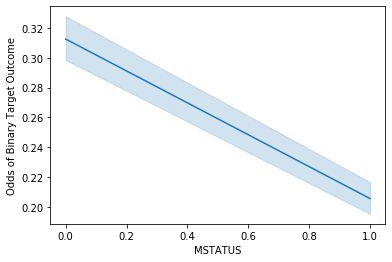

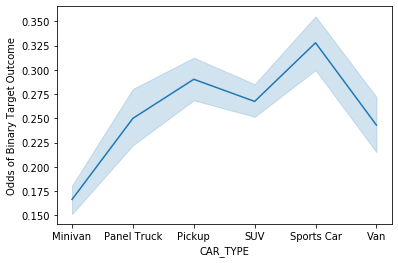

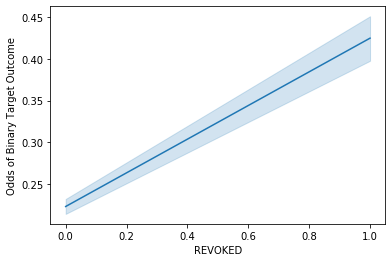

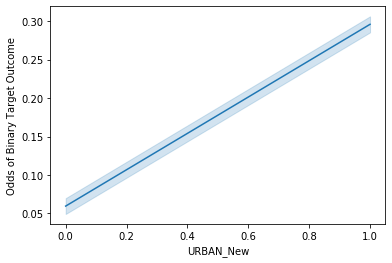

In [408]:
#line chart plots for catogorical features
cat_var = ['MSTATUS', 'CAR_TYPE', 'REVOKED', 'URBAN_New', 'freq_larger_1']
int_var = ['TIF', 'MVR_PTS', 'TRAVTIME', 'CAR_AGE', 'freq_larger_1']

cat_col = data_train[cat_var]
for i in ['MSTATUS', 'CAR_TYPE', 'REVOKED', 'URBAN_New']:
    cat_odds = cat_col.groupby([i]).mean()
    cat_odds = cat_col.sort_index()
    sns.lineplot(x=cat_odds[i], y=cat_odds['freq_larger_1'])
    plt.xlabel(i)
    plt.ylabel('Odds of Binary Target Outcome')
    plt.show()
    

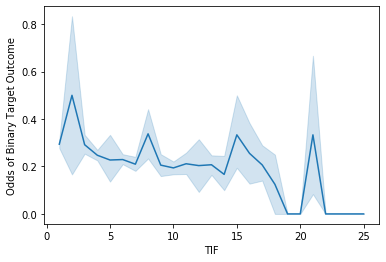

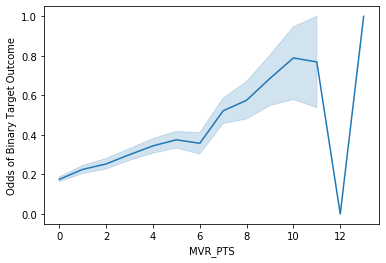

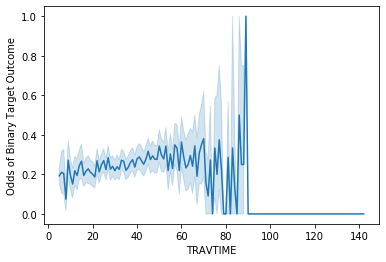

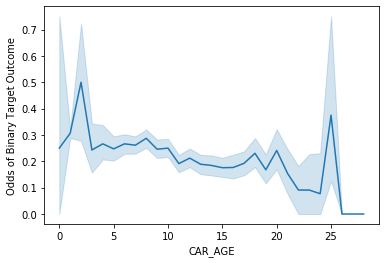

In [409]:
#Interval Variables plots
int_col = data_train[int_var]
for i in ['TIF', 'MVR_PTS', 'TRAVTIME', 'CAR_AGE']:
    int_odds = int_col.groupby([i]).mean()
    int_odds = int_col.sort_index()
    sns.lineplot(x=int_odds[i], y=int_odds['freq_larger_1'])
    plt.xlabel(i)
    plt.ylabel('Odds of Binary Target Outcome')
    plt.show()

#### Q1 B.	
Enter the predictors into your model using Forward Selection.  The Entry Threshold is 0.05. Please provide a detailed report of the Forward Selection. However, you do not need to show steps such as in the previous question.  The report should include (1) the predictor entered, (2) the log-likelihood value, (3) the Deviance Chi-squares statistic, (4) the Deviance Degree of Freedom, and (5) the Chi-square significance. 

In [410]:
#Split X and Y
x = data_dm.drop(['freq_larger_1','frequency'],axis = 1)
y = data_dm.freq_larger_1


In [411]:
scaler = MinMaxScaler()
features = x.columns.values
X, y = x.values, y.values
X_minmax = scaler.fit_transform(X)

X_train, X_test, y_train, y_test =\
    train_test_split(X_minmax, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

In [412]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics

lr = LogisticRegression(solver='liblinear', random_state=123)
dtree = DecisionTreeClassifier()

pipe = make_pipeline(RFE(estimator=lr, step=1))


parameters = {'rfe__n_features_to_select': range(1, X_train.shape[1])}

grid = GridSearchCV(pipe, param_grid=parameters, cv=10, n_jobs=-1)
grid.fit(X_train, y_train)

print('Best params:', grid.best_params_)
print('Best accuracy:', grid.best_score_)
print('Accuracy on test dataset', grid.best_estimator_.score(X_test, y_test))

Best params: {'rfe__n_features_to_select': 12}
Best accuracy: 0.7740663211348361
Accuracy on test dataset 0.7837185236288375


>2 0.752 (0.000)
>3 0.752 (0.002)
>4 0.760 (0.005)
>5 0.761 (0.006)
>6 0.765 (0.006)
>7 0.767 (0.006)
>8 0.768 (0.007)
>9 0.771 (0.008)
>10 0.771 (0.008)
>11 0.774 (0.009)
>12 0.777 (0.009)


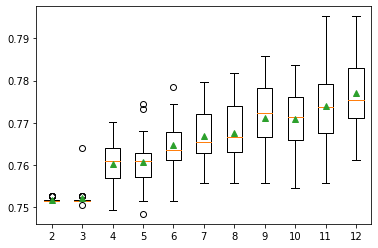

In [413]:
# get a list of models to evaluate
def get_models():
  models = dict()
  for i in range(2, X_train.shape[1]):
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
    model = LogisticRegression()
    models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
  return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, x, y):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
  return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, x, y)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

#### Q1 (C) 

Which predictors does your final model contain?

In [414]:
#(c)
lr = LogisticRegression(solver='liblinear', random_state=99)

rfe = RFE(estimator=lr, n_features_to_select=9, step=1)
rfe.fit(X_train, y_train)

print(rfe.support_)
print(x.columns[:][rfe.support_])


[ True  True  True  True  True  True  True  True False False False False
  True]
Index(['MSTATUS', 'REVOKED', 'CAR_AGE', 'TRAVTIME', 'MVR_PTS', 'TIF',
       'URBAN_New', 'CAR_TYPE_Minivan', 'CAR_TYPE_Van'],
      dtype='object')


From the above results, we can see that the RFE(Logistic estimator) select varibles:  ['MSTATUS', 'REVOKED', 'CAR_AGE', 'TRAVTIME', 'MVR_PTS', 'TIF',
       'URBAN_New', 'CAR_TYPE_Minivan', 'CAR_TYPE_Van']

In [415]:
# Decision Tree Feature Selection

rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=9, step=1)
rfe.fit(X_train, y_train)

print(rfe.support_)
print(x.columns[:][rfe.support_])

[False  True  True  True  True  True  True False False  True  True  True
 False]
Index(['REVOKED', 'CAR_AGE', 'TRAVTIME', 'MVR_PTS', 'TIF', 'URBAN_New',
       'CAR_TYPE_Pickup', 'CAR_TYPE_SUV', 'CAR_TYPE_Sports Car'],
      dtype='object')


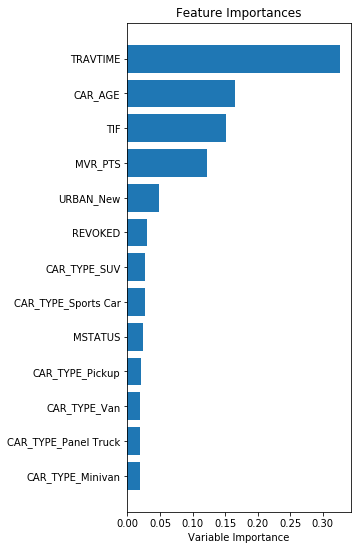

In [416]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

importances = clf.feature_importances_
indices = np.argsort(importances)

# Featrue importances Plot
fig = plt.subplots(figsize=(4,9))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Variable Importance')
plt.show()

From the above results, I can see that the RFE(Decision Tree)
select variables: (['REVOKED', 'CAR_AGE', 'TRAVTIME', 'MVR_PTS', 'TIF', 'URBAN_New',
       'CAR_TYPE_Pickup', 'CAR_TYPE_SUV', 'CAR_TYPE_Sports Car']

##### I decided to use decision tree feature selection results in my final model:

The features are I selected are: 'REVOKED', 'CAR_AGE', 'TRAVTIME', 'MVR_PTS', 'TIF', 'URBAN_New', 'CAR_TYPE_Pickup', 'CAR_TYPE_SUV', 'CAR_TYPE_Sports Car'

#### Q2(D)
Please show a table of the complete set of parameters of your final model. Please also include the exponentiated estimates (i.e., apply the exp() function on the parameter estimates).

In [417]:
#D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
X_NEW = x[['REVOKED', 'CAR_AGE', 'TRAVTIME', 'MVR_PTS', 'TIF', 'URBAN_New',
       'CAR_TYPE_Pickup', 'CAR_TYPE_SUV', 'CAR_TYPE_Sports Car']]

scaler = MinMaxScaler()
features = X_NEW.columns.values
X, y = X_NEW.values, Y.values
X_minmax = scaler.fit_transform(X)

X_train, X_test, y_train, y_test =\
    train_test_split(X_minmax, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

In [418]:
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C = 1, penalty = "l2", random_state = 1, fit_intercept=True)

logreg.fit(X_train, y_train)
y_train_pred_lg = logreg.predict(X_train)
y_val_pred_lg = logreg.predict(X_test)

print(f'Accuracy comparison: train vs test is {accuracy_score(y_train_pred_lg, y_train), accuracy_score(y_val_pred_lg, y_test)}')

Accuracy comparison: train vs test is (0.7691852728079255, 0.7719903414970679)


In [419]:
print(logreg.coef_, logreg.intercept_)

[[ 0.72720167 -1.35927302  1.78649594  2.17859472 -0.99933186  2.0151197
   0.45030231  0.39790586  0.6768607 ]] [-3.39139573]


In [420]:
selected = X_NEW.columns
data_selected = pd.DataFrame(data_dm, columns=selected)
data_dum_y = data_dm['freq_larger_1']

X_selected = sm.add_constant(data_selected)
logit_model=sm.Logit(data_dum_y, data_selected)
result=logit_model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.532049
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          freq_larger_1   No. Observations:                 9662
Model:                          Logit   Df Residuals:                     9653
Method:                           MLE   Df Model:                            8
Date:                Mon, 13 Feb 2023   Pseudo R-squ.:                 0.05048
Time:                        18:34:37   Log-Likelihood:                -5140.7
converged:                       True   LL-Null:                       -5414.0
Covariance Type:            nonrobust   LLR p-value:                6.858e-113
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
REVOKED                 0.6875      0.068     10.091      0.000       0.554       0.821
CA

C:\Users\Richa\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [421]:
result.params

REVOKED                0.687517
CAR_AGE               -0.089635
TRAVTIME              -0.014143
MVR_PTS                0.135876
TIF                   -0.102678
URBAN_New              0.457368
CAR_TYPE_Pickup       -0.023197
CAR_TYPE_SUV          -0.097179
CAR_TYPE_Sports Car    0.171340
dtype: float64

In [422]:
print(f'exponential esimates are: \n{np.exp(result.params)}')

exponential esimates are: 
REVOKED                1.988770
CAR_AGE                0.914264
TRAVTIME               0.985957
MVR_PTS                1.145540
TIF                    0.902418
URBAN_New              1.579910
CAR_TYPE_Pickup        0.977070
CAR_TYPE_SUV           0.907394
CAR_TYPE_Sports Car    1.186894
dtype: float64


#### Q2 You will visually assess your final model in Question 1.  Please color-code the markers according to the Exposure value.  Also, please briefly comment on the graphs.


A.	Please plot the predicted Event probability versus the observed Frequency.


In [423]:
#reselect columns from the data
selected = X_NEW.columns
data_selected = pd.DataFrame(data_dm, columns=selected)
data_dum_y = data_dm['freq_larger_1']

In [424]:
scaler = MinMaxScaler()
features = data_selected.columns.values
X, y = data_selected.values, data_dum_y.values
X_minmax = scaler.fit_transform(X)

In [425]:
y_pred = logreg.predict(X_minmax)
prob = logreg.predict_proba(X_minmax)[:,1]

In [426]:
freq = data_train.frequency

In [427]:
cols = ['Frequency','Probability']
plotdata = pd.DataFrame(columns=cols)

plotdata['Frequency'] = freq
plotdata['Probability'] = prob

plotdata.head()

,Frequency,Probability
0,0.0,0.114420
1,0.0,0.230917
2,0.0,0.222230
3,0.0,0.252374
4,0.0,0.172888


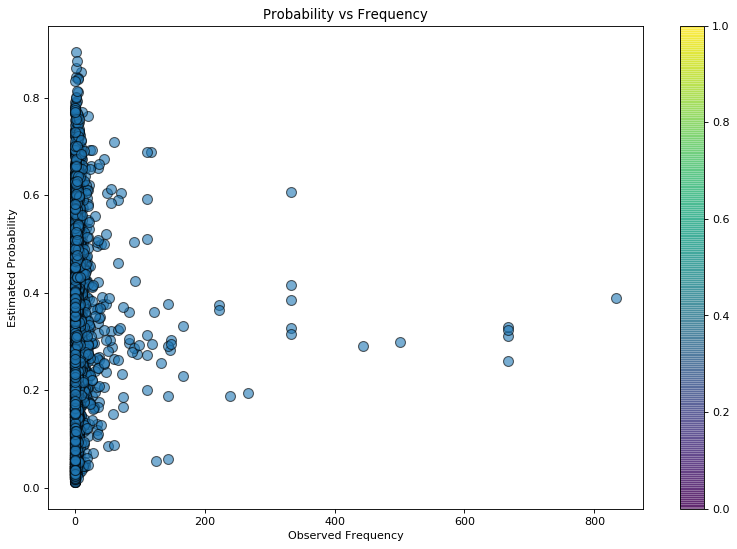

In [428]:
y = plotdata.Probability
x = plotdata.Frequency

fig = plt.figure(figsize=(12, 8), dpi=80)
plt.scatter(x, y, s=80, alpha=0.6, edgecolor='black',
            cmap='Blues')
plt.title('Probability vs Frequency')
plt.ylabel('Estimated Probability')
plt.xlabel('Observed Frequency')
plt.colorbar()

#### Q2 B. Please plot the Deviance residuals versus the observed Frequency.

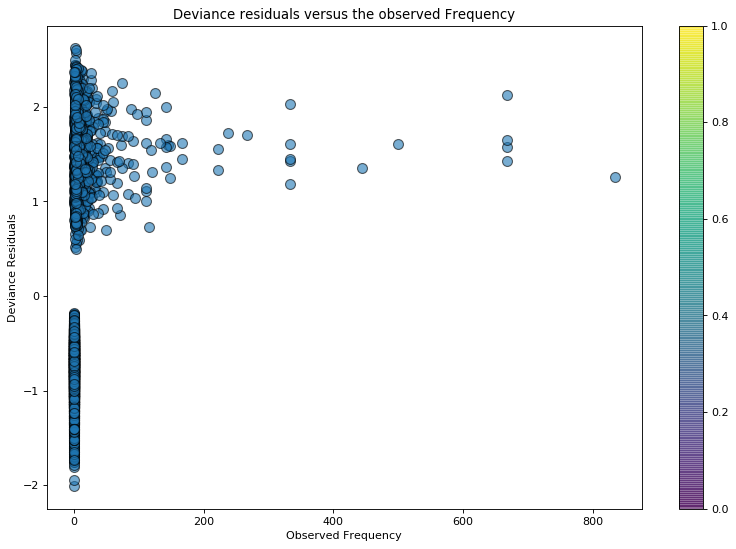

In [429]:
y = result.resid_dev
x = points.Frequency

fig = plt.figure(figsize=(12, 8), dpi=80)
plt.scatter(x, y, s=80, alpha=0.6, edgecolor='black',
            cmap='Blues')

plt.title('Deviance residuals versus the observed Frequency')
plt.ylabel('Deviance Residuals')
plt.xlabel('Observed Frequency')

plt.colorbar()

#### Q3. 

###### You will calculate the Accuracy metric to assess your final model in Question 3.  If the predicted Event probability of an observation is greater than or equal to 0.25, then you will classify that observation as the Event (i.e., filing more than one claim per unit exposure).  An observation is correctly classified if the predicted target value equals the observed target value.  The Accuracy metric is the proportion of observations that are correctly classified.

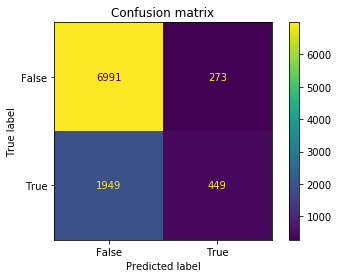

Accuracy is : 0.7700269095425378


In [430]:
y = data_dum_y.values
confusion_matrix = metrics.confusion_matrix(y, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.title("Confusion matrix")
plt.show()

print("Accuracy is :", accuracy_score(y,y_pred))

In [431]:
points['y'] = y
points['y_pred'] = y_pred
#Adjusted Prediction
points['y_prob'] = prob
points['y_pred_adj'] = points['y_prob'].apply(lambda x: 1 if x >= 0.25 else 0)

points.head(3)

,Frequency,Probability,y,y_pred,y_prob,y_pred_adj
0,0.0,0.114420,0,0,0.114420,0
1,0.0,0.230917,0,0,0.230917,0
2,0.0,0.222230,0,0,0.222230,0


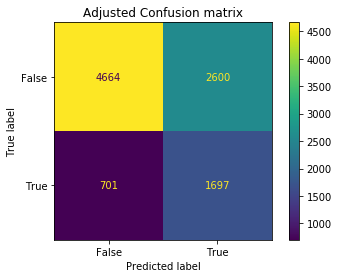

In [432]:
# confusion matrix after adjusted

confusion_matrix = metrics.confusion_matrix(y, points.y_pred_adj)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.title("Adjusted Confusion matrix")
plt.show()

In [433]:
#Compare the Accuracy
print(f'prediction\n{accuracy_score(y, y_pred)}')

prediction
0.7700269095425378


In [434]:
print(f'prediction after adjusted \n{accuracy_score(y, points.y_pred_adj)}')

prediction after adjusted 
0.6583523080107638
